In [5]:
DATA_FOLDER_PATH = "data/cleaned"

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [7]:
data = {}
for file_name in os.listdir(DATA_FOLDER_PATH):
    title = ".".join(file_name.split(".")[:-1])
    file_path = DATA_FOLDER_PATH + "/" + file_name
    data[title] = pd.read_csv(file_path)
    data[title]["Дата"] = pd.to_datetime(data[title]["Дата"], format="%Y-%m-%d %H:%M:%S")
months_order = sorted(list(data.keys()), key=lambda month: data[month]["Дата"][0])
months_order

['1.2019',
 '2.2019',
 '3.2019',
 '4.2019',
 '5.2019',
 '6.2019',
 '7.2019',
 '8.2019',
 '9.2019',
 '10.2019',
 '11.2019',
 '12.2019',
 '1.2020',
 '2.2020',
 '3.2020',
 '4.2020',
 '5.2020',
 '6.2020',
 '7.2020',
 '8.2020',
 '9.2020',
 '10.2020',
 '11.2020',
 '12.2020',
 '1.2021']

In [8]:
data["1.2019"].head()

,Дата,Потребление
0,2019-01-01 00:30:00,0.925121
1,2019-01-01 01:00:00,0.925511
2,2019-01-01 01:30:00,0.925123
3,2019-01-01 02:00:00,0.922214
4,2019-01-01 02:30:00,0.912388


In [9]:
# группировка данных по часам (изначально было по полчаса)
for month in data:
    corrected_data = {"Дата": [], "Потребление": []}
    for i in range(1, data[month].shape[0], 2):
        corrected_data["Дата"].append(data[month].iloc[i, 0])
        corrected_data["Потребление"].append(data[month].iloc[i, 1] + data[month].iloc[i - 1, 1])
    data[month] = pd.DataFrame(data=corrected_data)
data["1.2019"].head()

,Дата,Потребление
0,2019-01-01 01:00:00,1.850632
1,2019-01-01 02:00:00,1.847337
2,2019-01-01 03:00:00,1.823589
3,2019-01-01 04:00:00,1.822738
4,2019-01-01 05:00:00,1.847779


In [6]:
URL_TEMPLATE = "http://pogoda-service.ru/archive_gsod_res.php?country=RS&station={s}&datepicker_beg={b}&datepicker_end={e}"
DATE_FORMAT = "%d.%m.%Y"
CITIES_NAMES_PATH = "cities.csv"

def parse_wheather(search_city, first_date, last_date):
    cities_df = pd.read_csv(CITIES_NAMES_PATH, delimiter=",")
    cities_df.loc[cities_df.city == search_city]
    url = URL_TEMPLATE.format(
        s=str(cities_df.loc[cities_df.city == search_city].station.item()),
        b=first_date,
        e=last_date
    )
    df = pd.read_html(url)[0]
    df.columns = ["date", "max_temp", "min_temp", "mid_temp", "atmo", "wind", "rain", "ef_temp"]
    df.drop(columns=["atmo", "wind", "rain", "ef_temp"], axis=1, inplace=True)
    return df

In [7]:
CITY = "Архангельск"
temperatures = parse_wheather(CITY, "01.01.2019", "31.01.2020")
print(temperatures.dtypes)
temperatures.tail()

date         object
max_temp    float64
min_temp    float64
mid_temp    float64
dtype: object


,date,max_temp,min_temp,mid_temp
387,27.01.2020,-18.0,-26.2,-21.3
388,28.01.2020,-15.7,-28.0,-22.3
389,29.01.2020,-19.8,-29.3,-24.7
390,30.01.2020,-20.9,-28.3,-24.1
391,31.01.2020,-23.7,-30.8,-26.3


In [11]:
def get_train_data(data, begin_month="1.2019", end_month="1.2021"):
    return pd.concat(
        [data[month] for month in months_order[months_order.index(begin_month):months_order.index(end_month) + 1]],
        ignore_index=True
    )

In [7]:
def error(real, predicted, mean=True):
    real_values = real["Потребление"].to_numpy()
    errors = np.abs(real_values - predicted) / np.abs(real_values)
    return np.mean(errors) if mean else np.median(errors)

def draw_results(real, predicted, title=""):
    real_values = real["Потребление"].to_numpy()
    results_predict = pd.DataFrame(
        data={
            "real": real_values,
            "predicted": predicted
        }
    )
    results_predict.plot(figsize=(17, 4))
    plt.title(title)
    plt.show()

def test_model(model, real_data, d=1, draw_plot=True, mean=True, title="", **kwargs):
    predicted_values = model.predict(d=d, **kwargs)
    
    if draw_plot:
        draw_results(real_data, predicted_values, title)
    
    real_sum = real_data["Потребление"].sum()
    predicted_sum = predicted_values.sum()
    
    return error(real_data, predicted_values, mean), abs(real_sum - predicted_sum) / abs(real_sum)

## Модель Уинтерса (без тренда)

In [20]:
class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train, alpha):
        y = train["Потребление"]
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = y.mean()
        
        for t in range(self.s):
            self.theta[t] = y[t]
            self.a[t] = m
        
        for t in range(s, self.n):
            if self.theta[t - self.s] != 0:
                self.a[t] = alpha[0] * (y[t] / self.theta[t - self.s]) + (1 - alpha[0]) * self.a[t - 1]
            else:
                self.a[t] = (1 - alpha[0]) * self.a[t - 1]
            if self.a[t] != 0:
                self.theta[t] = alpha[1] * (y[t] / self.a[t]) + (1 - alpha[1]) * self.theta[t - self.s]
            else:
                self.theta[t] = (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d=1):
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted

<AxesSubplot:>

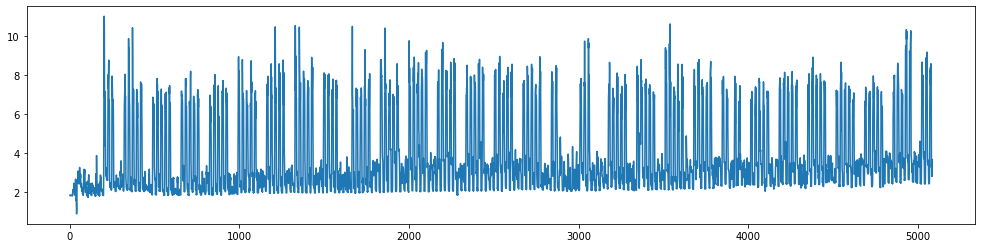

In [10]:
prev_month = "7.2019"
predict_month = "8.2019"
train_data = get_train_data(data, begin_month="1.2019", end_month="7.2019")
train_data["Потребление"].plot(figsize=(17, 4))

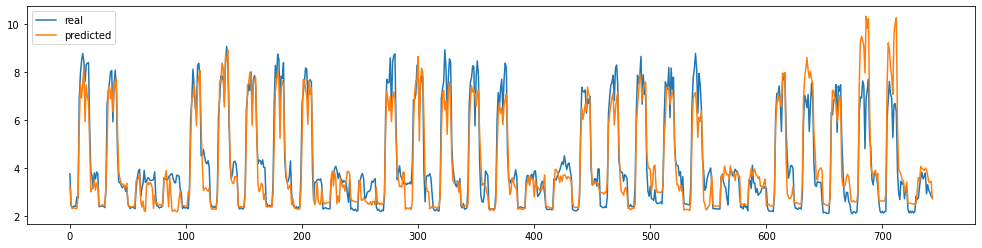

Errors - per hour: 0.10379450925772984, month sum: 0.024771026032808372


In [11]:
def optimize_alpha(alpha, s, train_data, real_data):
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    predicted_data = winters_model.predict(real_data.shape[0])
    
    return ((predicted_data - real_data["Потребление"].to_numpy())**2).sum()

alpha = np.array([0, 1])
s = 1 * 7 * 24
d = min(1 * 31 * 24, data[predict_month].shape[0])
real_next_values = data[predict_month].iloc[:d, :]

winters_model = WintersNoTrend(s)
winters_model.fit(train_data, alpha)

errors = test_model(winters_model, real_next_values, d=d, mean=False)
print("Errors - per hour: {}, month sum: {}".format(*errors))

Optimized alpha: [0.00242439 0.20285751]


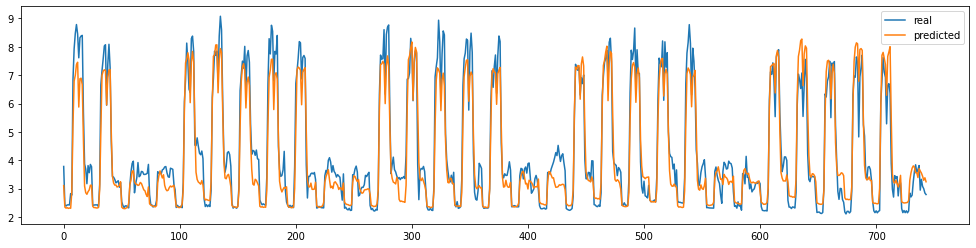

Errors - per hour: 0.08837584782092796, month sum: 0.037870659382816765


In [13]:
result = minimize(lambda x: optimize_alpha(x, s, train_data, real_next_values),
                 x0=np.array([0, 1]),
                 bounds=[(0, 1), (0, 1)])
alpha_optimized = result.x
print("Optimized alpha: " + str(alpha_optimized))

winters_model_optimized = WintersNoTrend(s)
winters_model_optimized.fit(train_data, alpha_optimized)

errors = test_model(winters_model_optimized, real_next_values, d=d, mean=False)
print("Errors - per hour: {}, month sum: {}".format(*errors))

### Применение информации о температуре

Optimized temperatures weights: [ 0.02618863  0.02816838 -0.00110627 -0.00809193 -0.00800155 -0.00533223
 -0.00492278 -0.00713478 -0.00414175 -0.00901091  0.02044326  0.01246495
 -0.00422659  0.01357366  0.01936433  0.03418645  0.02476581  0.04180133
 -0.02521711  0.0078888   0.02092989  0.032444    0.02083365  0.04047361]


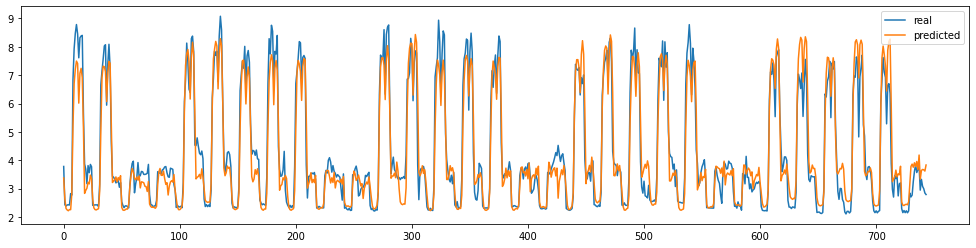

Errors - per hour: 0.08254902107589981, month sum: 0.00795901861443564


In [14]:
from datetime import timedelta

class ModelWithTemp:
    def __init__(self, model, temp_weights=None):
        self.temp_weights = np.zeros(24) if temp_weights is None else temp_weights
        self.model = model
    
    def fit(self, train_data, real_data, temperatures, d):
        model_predictions = self.model.predict(d)
        hours = real_data["Дата"].apply(lambda date: date.hour).values
        def error_with_temp(temp_weights):
            return error(real_data, model_predictions + temp_weights[hours] * temperatures)
        self.temp_weights = minimize(error_with_temp, x0=self.temp_weights).x
    
    def predict(self, d, temperatures):
        model_predictions = self.model.predict(d)
        full_temps_weights = np.array([self.temp_weights[i % 24] for i in range(d)])
        return model_predictions + full_temps_weights * temperatures

temp_model = ModelWithTemp(winters_model_optimized)
curr_temperatures = np.zeros(d)
for i in range(d):
    real_date = real_next_values.iloc[i, 0].strftime("%d.%m.%Y")
    curr_temperatures[i] = temperatures[temperatures["date"] == real_date].iloc[0, 3]
temp_model.fit(train_data, real_next_values, curr_temperatures, d)
optimized_temp_weights = temp_model.temp_weights
print("Optimized temperatures weights: " + str(optimized_temp_weights))

errors = test_model(temp_model, real_next_values, d=d, mean=False, temperatures=curr_temperatures)
print("Errors - per hour: {}, month sum: {}".format(*errors))

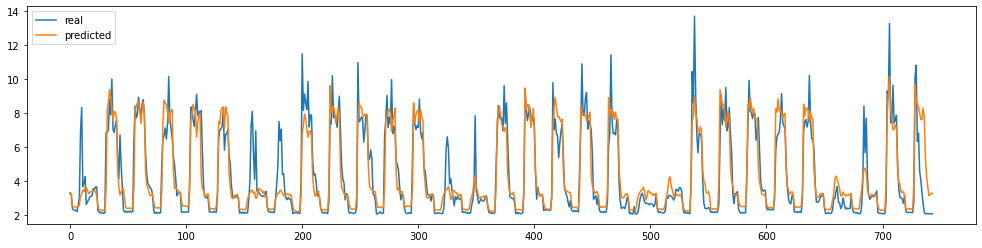

Only Winters: errors - per hour: 0.11039684175131104, month sum: 0.012769079549858823


NameError: name 'ModelWithTemp' is not defined

In [14]:
prev_month = "11.2019"
predict_month = "12.2019"
train_data = get_train_data(data, begin_month="9.2019", end_month=prev_month)
real_next_values = data[predict_month].iloc[:d, :]

alpha_optimized = minimize(lambda x: optimize_alpha(x, s, train_data, real_next_values),
                 x0=np.array([0, 1]),
                 bounds=[(0, 1), (0, 1)]).x

winters_model_optimized = WintersNoTrend(s)
winters_model_optimized.fit(train_data, alpha_optimized)
errors = test_model(winters_model_optimized, real_next_values, d=d, mean=False)
print("Only Winters: errors - per hour: {}, month sum: {}".format(*errors))

curr_temperatures = np.zeros(d)
for i in range(d):
    real_date = real_next_values.iloc[i, 0].strftime("%d.%m.%Y")
    curr_temperatures[i] = temperatures[temperatures["date"] == real_date].iloc[0, 3]
# plt.plot(curr_temperatures)
temp_model_optimized = ModelWithTemp(winters_model_optimized, temp_weights=optimized_temp_weights)
errors = test_model(temp_model_optimized, real_next_values, d=d, mean=False, temperatures=curr_temperatures)
print("Winters with temperatures: errors - per hour: {}, month sum: {}".format(*errors))

## Адаптивная авторегрессионная модель

In [15]:
class AutoRegression:
    def __init__(self, k): # k -- ширина окна
        self.k = k
        self.W = np.random.randn(self.k) / 100
    
    def fit(self, train, alpha): # train -- numpy array со значениями потребления, alpha -- аналог параметра сглаживания для обучения
        y_predicted = train.copy()
        n = y_predicted.shape[0]
        
        h = np.zeros(n)
        eps = np.zeros(n)
        
        for t in range(self.k, n):
            y_predicted[t] = sum(self.W[j] * train[t - j - 1] for j in range(self.k))
            eps[t] = train[t] - y_predicted[t]
            h[t] = alpha / sum(train[t - j]**2 for j in range(self.k))
            self.W += h[t] * eps[t] * np.array([train[t - j] for j in range(self.k)])
            y_predicted[t] = train[t]
    
    def predict(self, previous_data, d=1): # d -- горизонт прогнозирования
        y_predicted = np.hstack([previous_data.copy(), np.zeros(d)])
        
        n = previous_data.shape[0]
        for t in range(n, n + d):
            y_predicted[t] = sum(self.W[j] * y_predicted[t - j - 1] for j in range(self.k))
        
        return y_predicted[n:]
    
d = 31 * 48

alpha = 0.01
k = 1 * 1 * 48

auto_regr_model = AutoRegression(k)
auto_regr_model.fit(train_data, alpha)

real_next_values = data[predict_month]["Потребление"][:d]
test_model(auto_regr_model, real_next_values, d, previous_data=train_data)

KeyError: 47

In [ ]:
class AutoRegressionTriggLeach:
    def __init__(self, k): # k -- ширина окна
        self.k = k
        self.W = np.zeros(self.k)
    
    def fit(self, train, gamma): # train -- numpy array со значениями потребления,
        
        y_predicted = train.copy()
        n = y_predicted.shape[0]
        
        h = np.zeros(n)
        eps = np.zeros(n)
        eps_hat = np.zeros(n)
        eps_tilde = np.zeros(n)
        K = np.zeros(n)
        
        for t in range(self.k, n):
            y_predicted[t] = sum(self.W[j] * train[t - j - 1] for j in range(self.k))
            
            eps[t] = train[t] - y_predicted[t]
            if t > self.k:
                eps_hat[t] = gamma * eps[t - 1] + (1 - gamma) * eps_hat[t - 1]
                eps_tilde[t] = gamma * abs(eps[t - 1]) + (1 - gamma) * eps_tilde[t - 1]
                K[t] = eps_hat[t] / eps_tilde[t]
                alpha = abs(K[t])
            else:
                alpha = 0.1
            
            h[t] = alpha / sum(train[t - j]**2 for j in range(self.k))
            self.W += h[t] * eps[t] * np.array([train[t - j] for j in range(self.k)])
            y_predicted[t] = train[t]
    
    def predict(self, previous_data, d=1): # d -- горизонт прогнозирования
        y_predicted = np.hstack([previous_data.copy(), np.zeros(d)])
        
        n = previous_data.shape[0]
        m = previous_data.min()
        for t in range(n, n + d):
            y_predicted[t] = max(sum(self.W[j] * y_predicted[t - j - 1] for j in range(self.k)), m)
        
        return y_predicted[n:]

d = 1 * 48
real_data = data[predict_month]["Потребление"][:d]

gamma = 0.09
k = 1 * 48

trigg_leach_model = AutoRegressionTriggLeach(k)
trigg_leach_model.fit(train_data, gamma)

test_model(trigg_leach_model, real_data, d, previous_data=train_data)

In [ ]:
train_data.plot(figsize=(17, 4))

## Композиция моделей Уинтерса

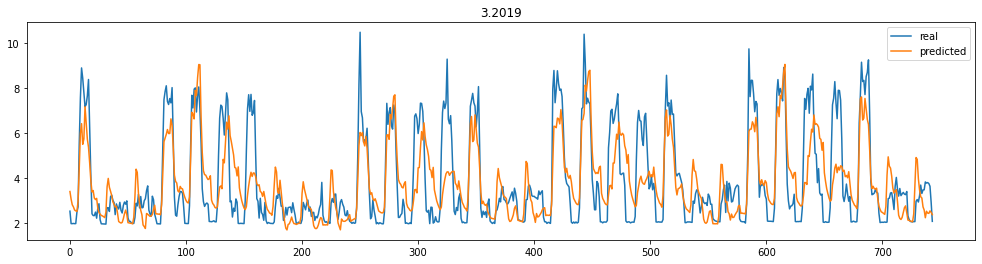

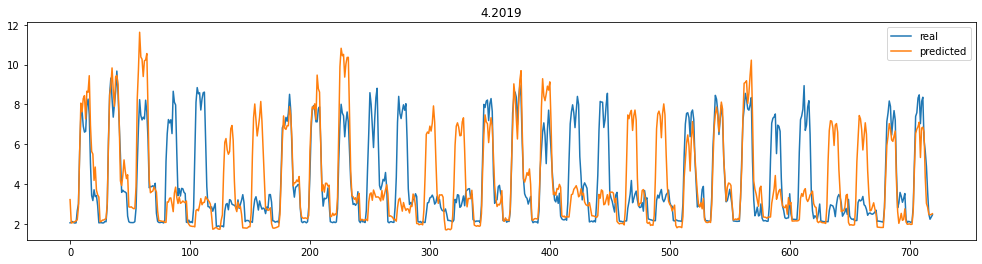

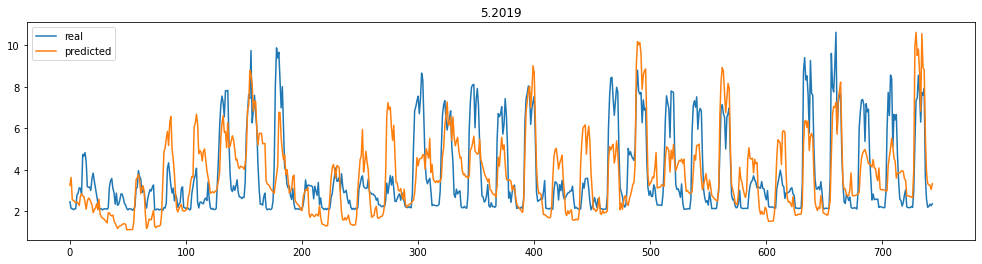

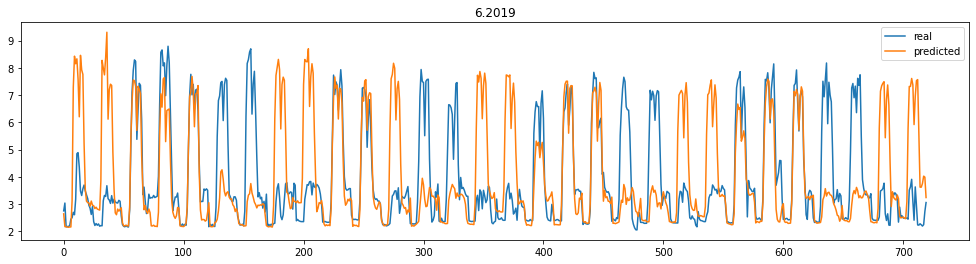

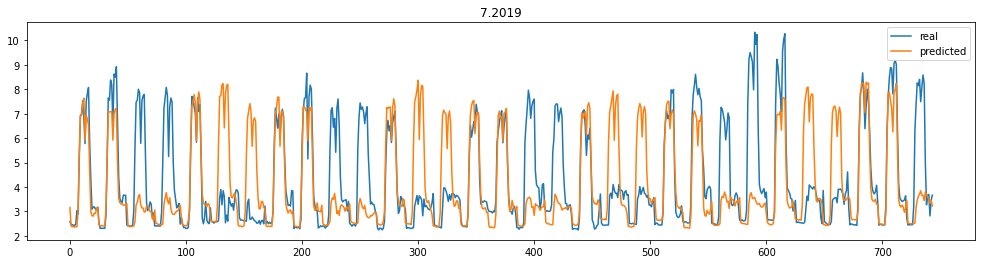

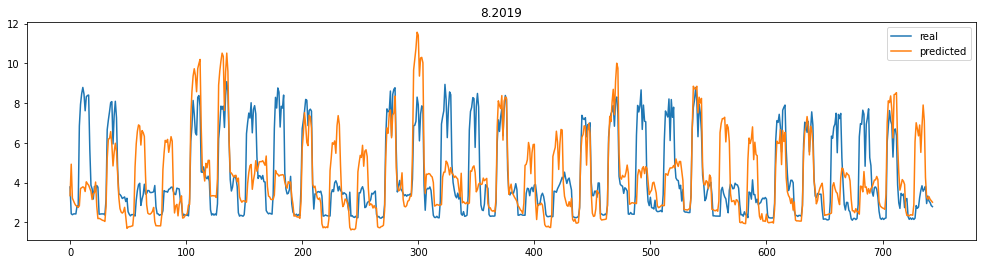

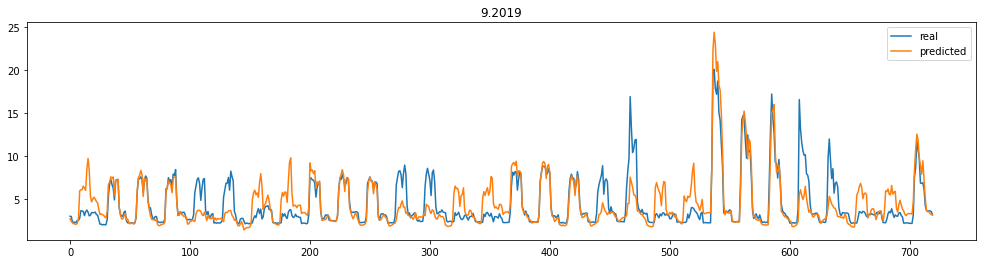

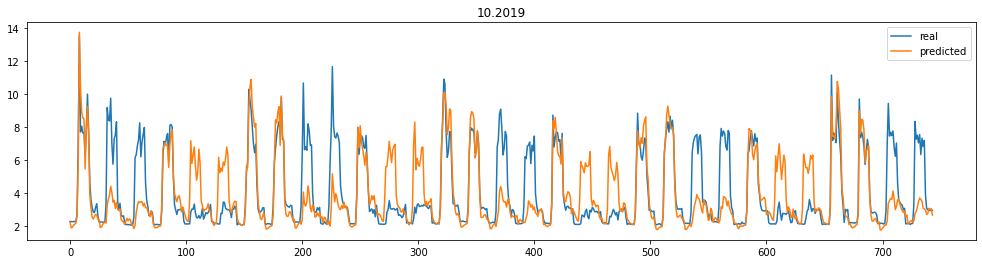

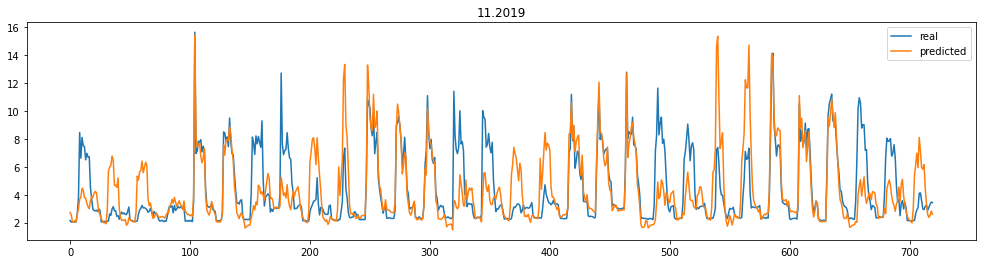

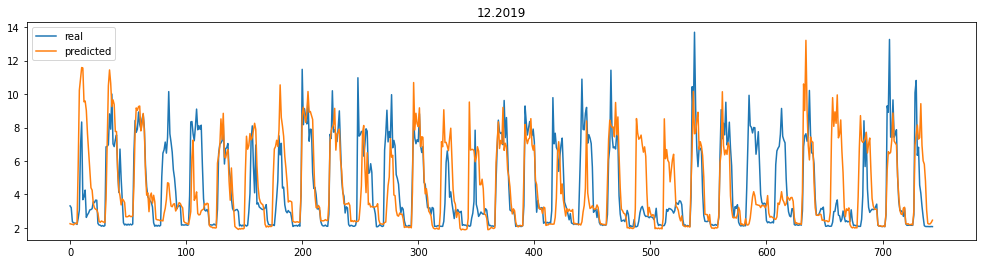

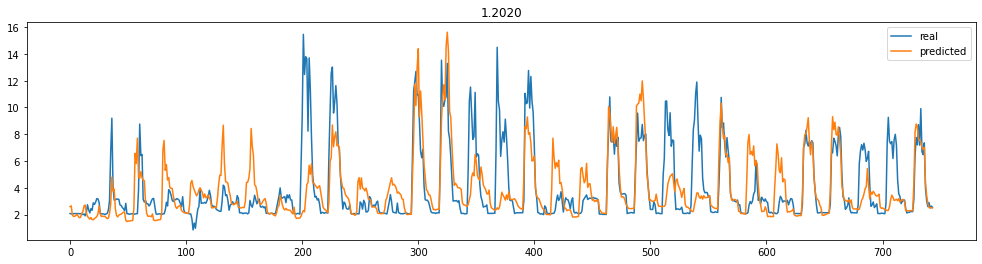

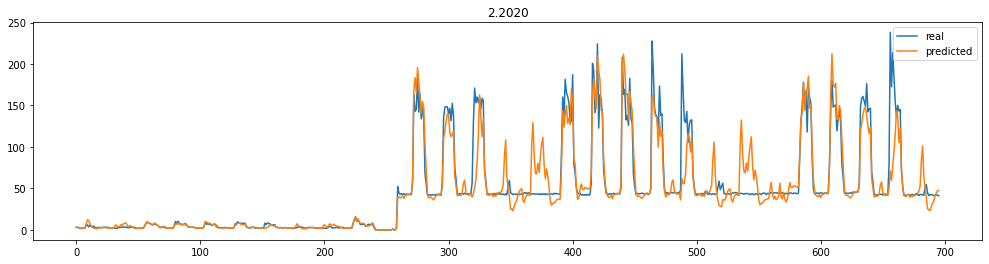

c:\users\ov4t\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


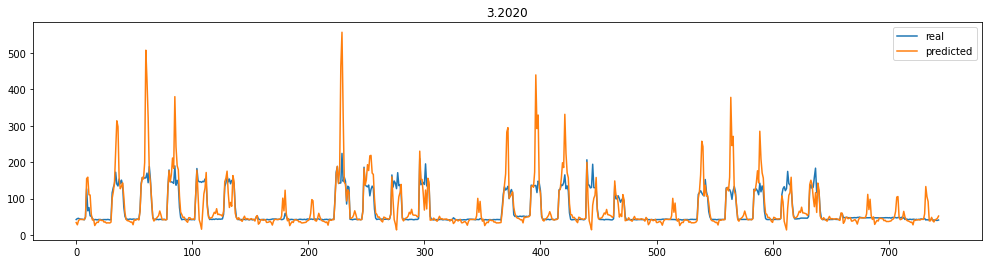

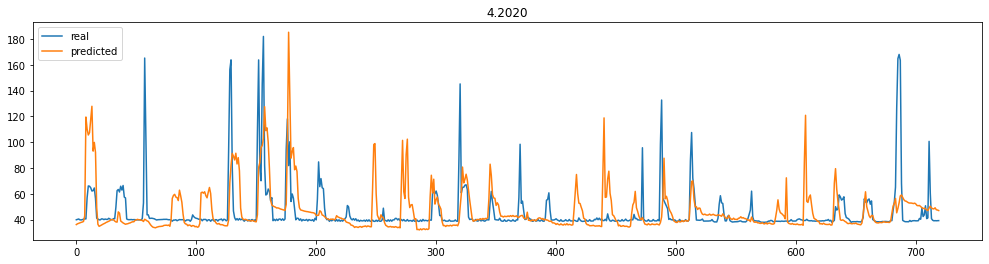

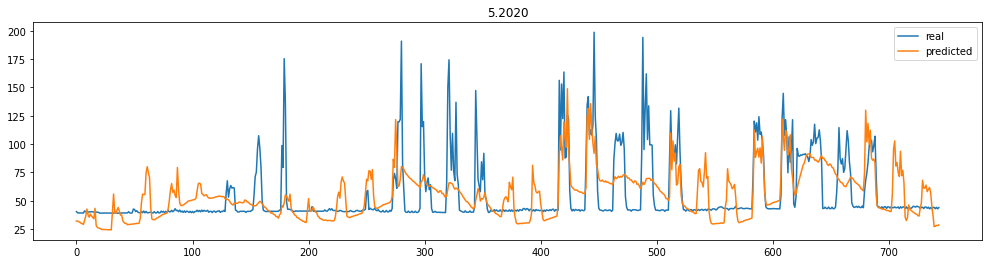

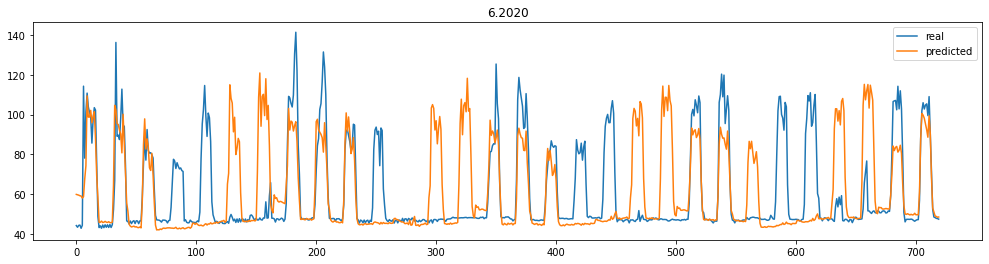

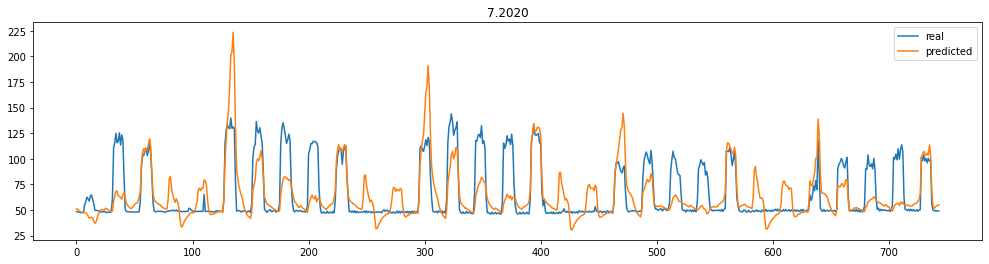

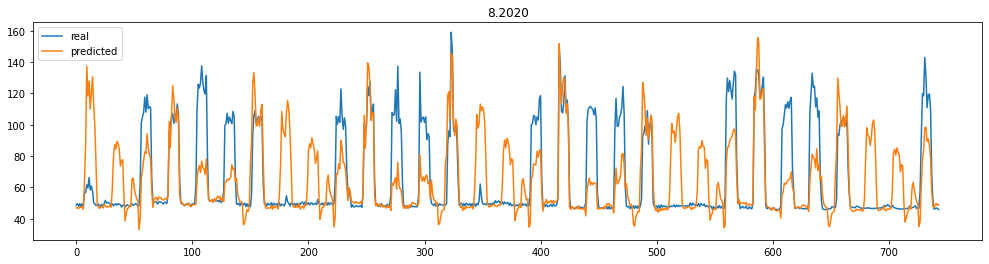

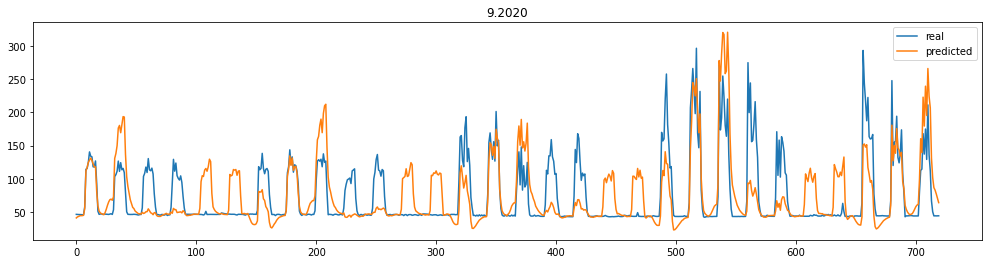

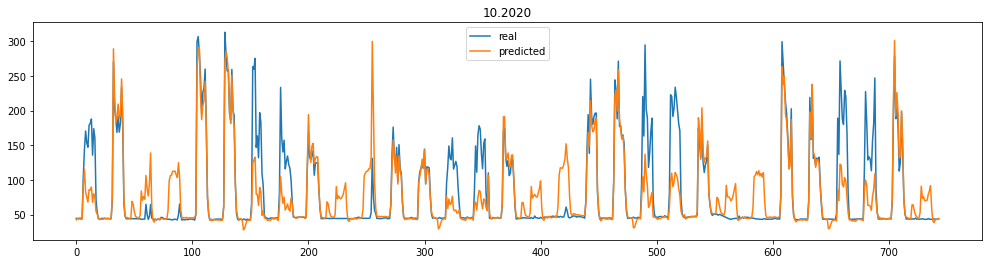

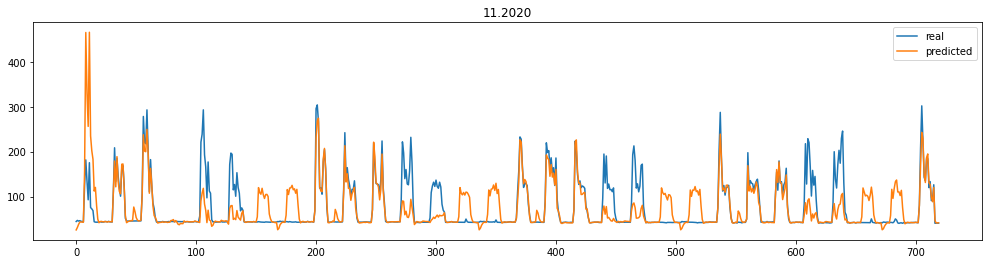

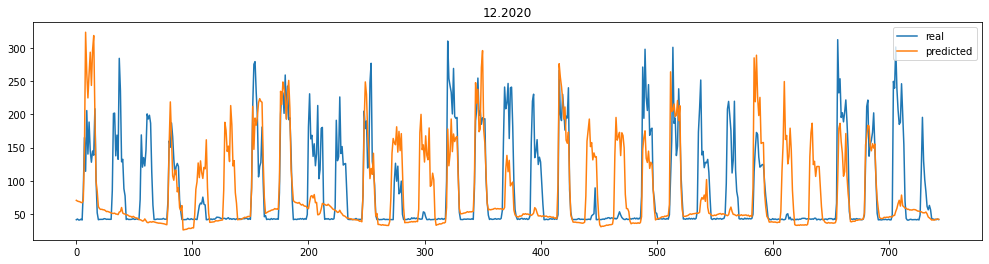

In [29]:
winters_models = []
n = len(months_order)
predict_month = months_order[-2]
s = 7 * 24
d_default = 31 * 24
for i in range(2, n - 1):
#     predict_month = months_order[i]
    train_data = get_train_data(data, begin_month=months_order[i - 2], end_month=months_order[i])
    real_data = data[months_order[i]]
    d = min(d_default, real_data.shape[0])
    result = minimize(lambda x: optimize_alpha(x, s, train_data, real_data),
         x0=np.array([0, 1]),
         bounds=[(0, 1), (0, 1)]
    )
    alpha_optimized = result.x
    winters_models.append(WintersNoTrend(s))
    winters_models[-1].fit(train_data, alpha_optimized)
    test_model(winters_models[-1], real_data, d=d, mean=False, title=months_order[i])

In [16]:
class ModelsSelection:
    def __init__(self, models):
        self.models = models
        self.k = len(self.models)
    
    def fit(self, real_data, gamma):
        d = real_data.shape[0]
        predictions = np.array([model.predict(d) for model in self.models])
        epsilon = real_data.values[:, 1] - predictions
        epsilon_hat = np.zeros_like(epsilon)
        epsilon_hat[:, 0] = epsilon[:, 0]
        for t in range(1, d):
            epsilon_hat[:, t] = gamma * np.abs(epsilon[:, t]) + (1 - gamma) * epsilon_hat[:, t - 1]
        
        self.epsilon_hat = epsilon_hat
        
    def predict(self, d):
        predictions = np.array([model.predict(d) for model in self.models])
        y_predicted = np.zeros(d)
        for t in range(d):
            best = np.argmin(self.epsilon_hat[:, t])
            y_predicted[t] = predictions[best, t]
        return y_predicted

train_predict_month = months_order[-2]
real_data = data[train_predict_month]
sel = ModelsSelection(winters_models)
sel.fit(real_data, 0.1)
# print(np.sum(comp.w, axis=1))

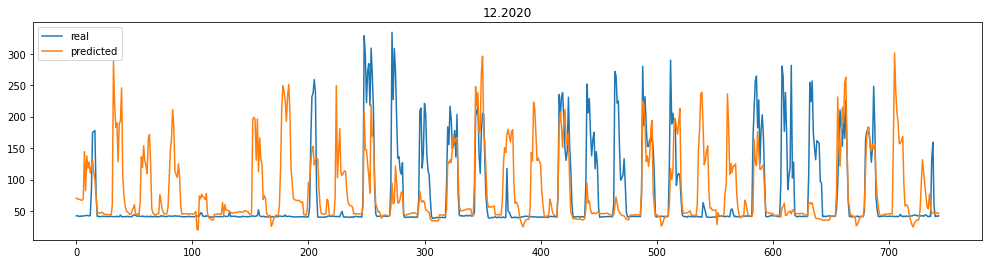

(0.2323633424730276, 0.1064925553043387)

In [18]:
predict_month = months_order[-1]
real_data = data[predict_month]
test_model(sel, real_data, d=real_data.shape[0], mean=False, title=train_predict_month)

In [21]:
train_data = get_train_data(data, begin_month=months_order[0], end_month=months_order[-2])
real_data = data[months_order[-1]]
result = minimize(lambda x: optimize_alpha(x, s, train_data, real_data),
     x0=np.array([0, 1]),
     bounds=[(0, 1), (0, 1)]
)
alpha_optimized = result.x
winters_model = WintersNoTrend(s)
winters_model.fit(train_data, alpha_optimized)
# winters_models.append(WintersNoTrend(s))

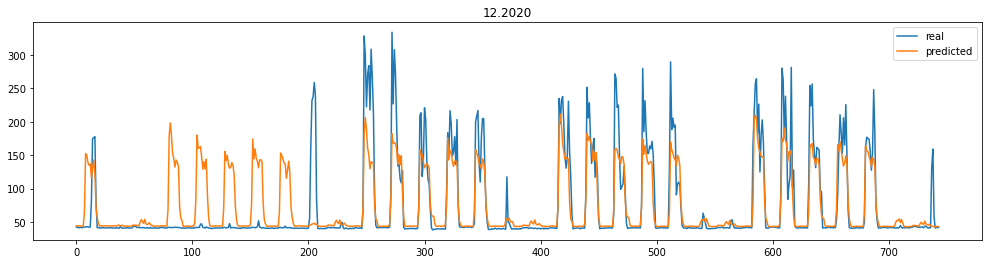

(0.08912782428150975, 0.017361214477658687)

In [22]:
test_model(winters_model, real_data, d=real_data.shape[0], mean=False, title=train_predict_month)

In [36]:
class ModelsComposition:
    def __init__(self, models):
        self.models = models
        self.k = len(self.models)
        self.w = None
    
    def fit(self, real_data, gamma):
        d = real_data.shape[0]
        predictions = np.array([model.predict(d) for model in self.models])
        epsilon = real_data.values[:, 1] - predictions
        epsilon_hat = np.zeros_like(epsilon)
        epsilon_hat[:, 0] = epsilon[:, 0]
        for t in range(1, d):
            epsilon_hat[:, t] = gamma * np.abs(epsilon[:, t]) + (1 - gamma) * epsilon_hat[:, t - 1]
        
        inversed = epsilon_hat ** (-1)
        self.w = inversed / inversed.sum(axis=0, keepdims=True)
        
    def predict(self, d):
        predictions = np.array([model.predict(d) for model in self.models])
        y_predicted = np.zeros(d)
        for t in range(d):
            y_predicted[t] = np.sum(self.w[:, t] * predictions[:, t])
        return y_predicted

In [37]:
real_data = data[months_order[-2]]
comp = ModelsComposition(winters_models)
comp.fit(real_data, 0.1)

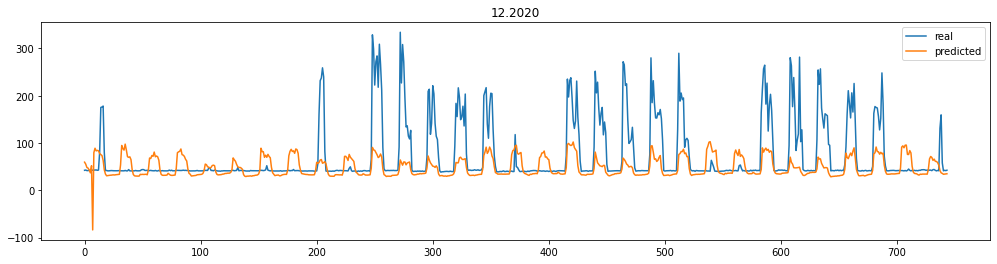

(0.24686315757929017, 0.3323146296757049)

In [38]:
real_data = data[months_order[-1]]
test_model(comp, real_data, d=real_data.shape[0], mean=False, title=train_predict_month)

<AxesSubplot:>

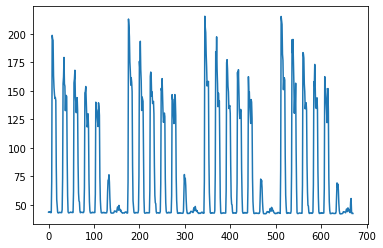

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize


class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train: pd.DataFrame, alpha: float):
        y = train.iloc[:, 1]
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = y.mean()
        
        for t in range(self.s):
            self.theta[t] = y[t]
            self.a[t] = m
        
        for t in range(self.s, self.n):
            if self.theta[t - self.s] != 0:
                self.a[t] = alpha[0] * (y[t] / self.theta[t - self.s]) \
                    + (1 - alpha[0]) * self.a[t - 1]
            else:
                self.a[t] = (1 - alpha[0]) * self.a[t - 1]
            if self.a[t] != 0:
                self.theta[t] = alpha[1] * (y[t] / self.a[t]) \
                    + (1 - alpha[1]) * self.theta[t - self.s]
            else:
                self.theta[t] = (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d: int=1) -> np.array:
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] \
                * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted


def alpha_optimizer(alpha: float, s: int, train_data: pd.DataFrame, \
                    real_data: pd.DataFrame) -> float:
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    predicted_data = winters_model.predict(real_data.shape[0])
    
    return ((predicted_data - real_data.iloc[:, 1].values)**2).sum()


def full_winters_pipeline(train_data: pd.DataFrame) -> pd.DataFrame:
    """ Функция, содержащая весь процесс получения прогноза 
    потребления от входных данных до результата прогнозирования.
    Принимает единственный аргумент train_data типа pd.DataFrame, 
    содержащий два столбца:
        - Первый - дата и время снятия потребления в формате 
            pandas.Timestamp или datetime.datetime;
        - Второй - собственно значение потребления.
    Предполагается, что в тренировочных данных предоставлены почасовые данные.
    Используется адаптивная модель Уинтерса без тренда с оптимизацией параметров 
    сглаживания на тренировочных данных.
    Определение количества прогнозируемых значений (от конца тренировочных данных 
    до конца последнего месяца) происходит автоматически.
    Функция возвращает объект pandas.DataFrame, имеющий ту же структуру, что и train_data.
    """
    
    time_delta = train_data.iloc[1, 0] - train_data.iloc[0, 0]
    last_date = train_data.iloc[-1, 0]
    
    before_dates = [last_date]
    while (last_date - before_dates[-1]).days < 30:
        before_dates.append(before_dates[-1] - time_delta)
    
    data_slice = train_data.iloc[:, 0].isin(before_dates)
    train, real = train_data[~data_slice], train_data[data_slice]
    
    s = 7 * 24 # период сезонности (7 дней по 24 часа)
    alpha_optimized = minimize(lambda x: alpha_optimizer(x, s, train, real),
         x0=np.array([0, 1]),
         bounds=[(0, 1), (0, 1)]
    ).x # оптимизация параметров сглаживания в модели Уинтерса
    
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha_optimized)
    
    predict_dates = [last_date + time_delta] # даты, на которые будет выполняться прогноз
    while (predict_dates[-1] + time_delta).month == last_date.month:
        predict_dates.append(predict_dates[-1] + time_delta)
    
    d = len(predict_dates) # горизонт прогнозирования
    result = pd.DataFrame(data={
        train_data.columns[0]: predict_dates,
        train_data.columns[1]: winters_model.predict(d)
    })
    
    return result


train_data = get_train_data(data, begin_month=months_order[0], end_month=months_order[-1])

prediction = full_winters_pipeline(train_data)

prediction.iloc[:, 1].plot()